In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.io.wavfile import read, write
from IPython.display import Audio
from numpy.fft import fft, ifft
import scipy
import math
import scipy.signal.windows as sgw
from scipy.signal import ShortTimeFFT
import os
import torch
import torchaudio
import pandas as pd
import io
from PIL import Image
from torchvision import datasets, transforms, utils
import matplotlib.cm as cm
from copy import deepcopy
import random
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
import torch.nn as nn
import os
import sys
import pickle
import seaborn as sn

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
audioPath = "/content/drive/MyDrive/assigments/UrbanSound8K/audio/"
csvPath = "/content/drive/MyDrive/assigments/UrbanSound8K/metadata/UrbanSound8K.csv"
modelPath = "/content/drive/MyDrive/models/"
musicPath = "/content/drive/MyDrive/music/"

In [4]:
outpth = r'D:\Sem3\Speech\Assignments\UrbanSound8K\Analysis/'
# metaDf = pd.read_csv(r"D:\Sem3\Speech\Assignments\UrbanSound8K\metadata\UrbanSound8K.csv")
metaDf = pd.read_csv(csvPath)
# print(len(metaDf['slice_file_name'].unique()))
# metaDf.index = metaDf['slice_file_name']
dct = metaDf[['slice_file_name','class']].set_index('slice_file_name').T.to_dict('list')
# print(dct)
# os.path.join(outpth,metaDf.iloc[[1,2], 0])

# def splitSample(Origfilepath, origFilename, split = (70,20,10)):
#     filepath = os.path.join(Origfilepath,origFilename)
#     metaDf = pd.read_csv(filepath)

metaDf.groupby('class').slice_file_name.count()

,slice_file_name
class,
air_conditioner,1000
car_horn,429
children_playing,1000
dog_bark,1000
drilling,1000
engine_idling,1000
gun_shot,374
jackhammer,1000
siren,929


In [5]:
#Custom function for data split
def balanced_split_into_train_val_test(df, stratify_colname='y', frac_train=0.7, frac_val=0.1, frac_test=0.2, random_state=None):
    uniqVal = df[stratify_colname].unique()
    total = len(df.index)
    indexList = {}
    for v in uniqVal:
        indexList[v] = (df.index[df[stratify_colname] == v].tolist())
    trainCount =  math.floor((total * frac_train)/len(uniqVal))
    validCount =  math.floor((total * frac_val)/len(uniqVal))
    testCount =  math.floor((total * frac_test)/len(uniqVal))

    counts = {"train": frac_train, "val": frac_val}
    masterlst = []
    allSample = {}
    for d,c in counts.items():
        allSample[d] = []
        for k,l in indexList.items():
            smple = []
            limit = math.floor(c * len(l))
            while len(smple) < limit:
                randNum = random.choice(l)
                if randNum not in masterlst:
                    masterlst.append(randNum)
                    smple.append(randNum)
            allSample[d] = allSample[d] + smple

    allSample["test"] = []
    for k,l in indexList.items():
        l = [i for i in l if i not in masterlst]
        allSample["test"] = allSample["test"] + l

    trainDf = df[df.index.isin(allSample["train"])]
    valDf = df[df.index.isin(allSample["val"])]
    testDf = df[df.index.isin(allSample["test"])]

    return trainDf, valDf, testDf

In [6]:
metaDf = pd.read_csv(csvPath)
trainDf, valDf, testDf = balanced_split_into_train_val_test(metaDf, stratify_colname="classID")

x_train = trainDf['slice_file_name']
y_train = trainDf['classID']
x_test = testDf['slice_file_name']
y_test = testDf['classID']
x_val = valDf['slice_file_name']
y_val = valDf['classID']

print("x train: ",x_train.shape)
print("y train: ",y_train.shape)
print("x test: ",x_test.shape)
print("y test: ",y_test.shape)
print("x Val: ",x_val.shape)
print("y val: ",y_val.shape)


x train:  (6111,)
y train:  (6111,)
x test:  (1750,)
y test:  (1750,)
x Val:  (871,)
y val:  (871,)


In [18]:
def manualSpectrogram(data, window, hoppercent, windowSize):
    N = len(data)
    n = torch.arange(0, windowSize, dtype=torch.float32)
    hopsize =  math.floor(hoppercent*windowSize/100)
    noOfWindows = np.linspace(0,int(N-windowSize),int(windowSize-hopsize))

    if window == 'hann':
        win = 0.5 * (1 - torch.cos(2 * torch.pi * n / (windowSize - 1))).numpy()
    elif window == 'hamming':
        win = (0.54 - 0.46 * torch.cos(2 * torch.pi * n / (windowSize - 1))).numpy()
    else:
        win = torch.ones(windowSize).numpy()

    spectMatrix = []
    for i in range(0,len(noOfWindows)):
        dataChunk = data[int(noOfWindows[i]) : int(noOfWindows[i] + windowSize)]
        dataChunk = dataChunk * win
        winfft = torch.fft.fft(dataChunk)
        spectMatrix.append(winfft)

    spectMatrix = torch.stack(spectMatrix,1)

    # spectMatrix[:,1:]
    f = int(windowSize/2.)
    frex = np.linspace(0,f,f+1)
    time = np.linspace(0,spectMatrix.shape[1],spectMatrix.shape[1])
    amp = np.abs(spectMatrix)

    # plt.axis('off') #https://www.geeksforgeeks.org/hide-axis-borders-and-white-spaces-in-matplotlib/
    # plt.pcolormesh(time,frex,amp[:f+1,:],vmin=0,vmax=2) #https://stackoverflow.com/questions/16120481/matplotlib-grayscale-heatmap-with-visually-distinct-na-squares-fields

    return time,frex,amp[:f+1,:]

# data,fs = torchaudio.load(f"{audioPath}/fold1/7061-6-0-0.wav")
# # print(data)
# data = data[0,:]
# pltlst = []
# manualSpectrogram(data, 'hann', 5, 1024)

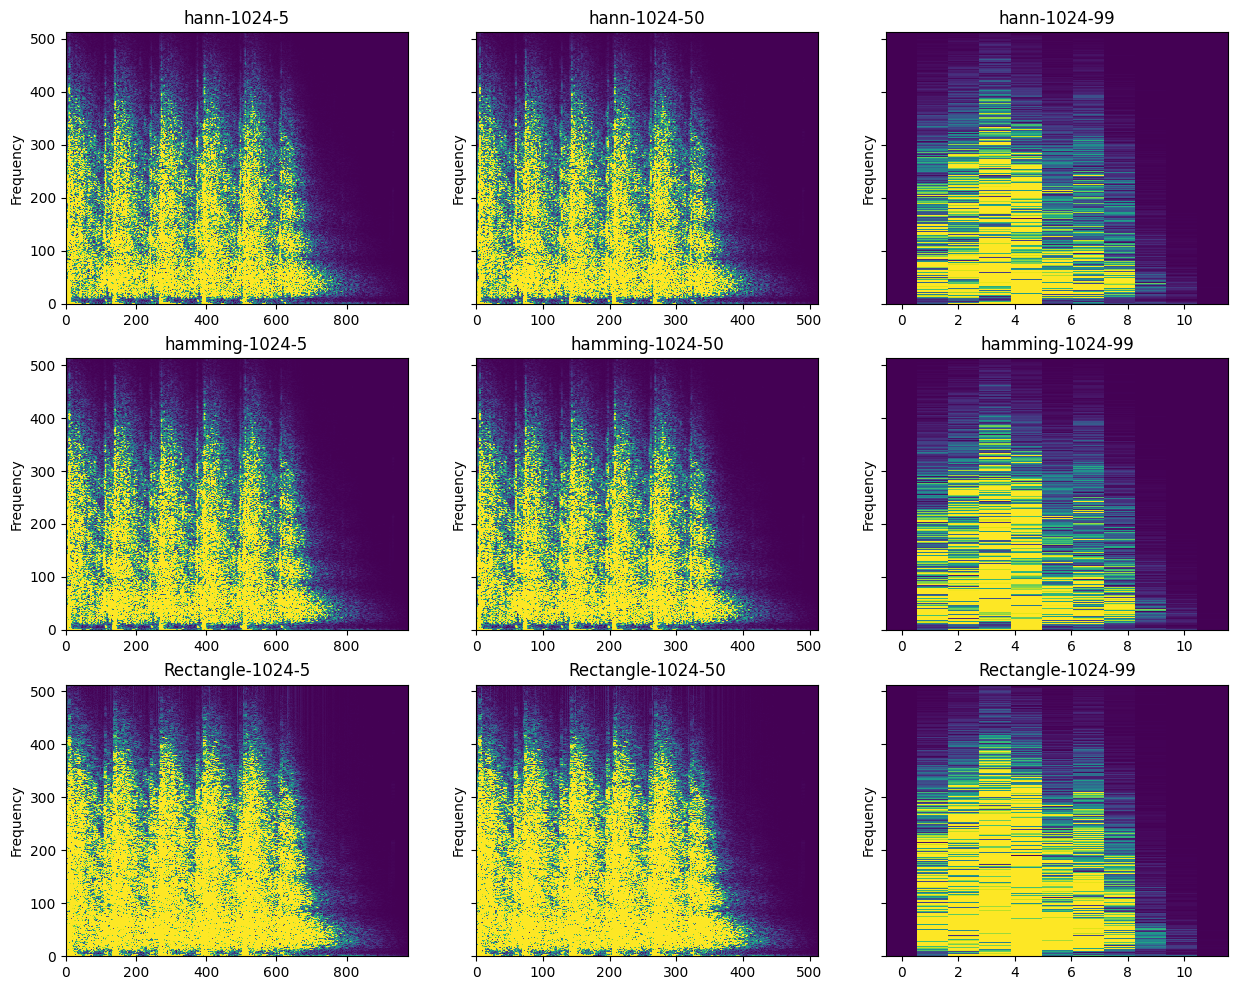

In [17]:
allcases = [("hann", 1024, 5), ("hann", 1024, 50), ("hann", 1024, 99), ("hamming", 1024, 5), ("hamming", 1024, 50), ("hamming", 1024, 99),("Rectangle", 1024, 5), ("Rectangle", 1024, 50), ("Rectangle", 1024, 99)]

fig, axs = plt.subplots(3, 3, sharey=True)
fig.set_size_inches(15,12)
allAx = axs.flat
# title = {0:"Varying Window Type", 2: "Varying Window Size", 1: "Varying Window Overlap"}
data,fs = torchaudio.load(f"{audioPath}/fold1/7061-6-0-0.wav")
data = data[0,:]
# print(f"{len(data)}-{fs}")


for ax, k in zip(allAx,allcases):
        wint, wins, hops = k
        time,frex,amp = manualSpectrogram(data, wint, hops, wins)
        ax.pcolormesh(time,frex,amp,vmin=0,vmax=2)
# for i, ax in enumerate(allAx):
        # if i in lst:
        #         ax.plot([i for i in range(len(dctr["tsa"]))],dctr["tsa"], label=f"{k[0]}-{k[1]}-{k[2]}")

# for i, ax in enumerate(allAx):
        # ax.legend()

        ax.set_title(f"{wint}-{wins}-{hops}")
        # ax.tight_layout()
        # ax.set_xlabel("Time")
        ax.set_ylabel("Frequency")

In [7]:
# https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
from torch.utils.data import Dataset

class AudioFolder(Dataset):
    def __init__(self, X, Y, folderpth, windowType = 'hann', windowSize = 1024, hopinpercent = 50, tranforms = None, derivation='inbuilt'):
        self.data = self.loadCSV(X,Y, folderpth)
        self.root = folderpth
        self.transforms = tranforms
        self.windowType = windowType
        self.windowSize = windowSize
        self.hopPercentage = hopinpercent
        self.derive = derivation

    def loadCSV(self, X,Y, basepath):
        fdfLst = []
        dct = {}
        # metaDf = pd.read_csv(metapath)
        # dct = metaDf[['slice_file_name','classID']].set_index('slice_file_name').T.to_dict('list')
        for x, y in zip(X,Y):
            dct[x] = y
        for root, dirs, files in os.walk(basepath):
            if os.path.basename(root) == os.path.basename(basepath):
                continue
            folderNm = os.path.basename(root)
            for f in files:
                fdct = {}
                if f not in dct.keys():
                    continue
                if '.' not in f[0]:
                    filepth = os.path.join(basepath,folderNm,f)
                    clsName = dct[f]
                    fdct = {"Path": filepth, "Label": clsName}
                    fdfLst.append(fdct)
        fdf = pd.DataFrame(fdfLst)
        fdf = fdf.reindex()
        return fdf

    def __len__(self):
        return len(self.data.index)

    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()
        path = self.data.iloc[index, 0]
        label = self.data.iloc[index, 1]
        image = self.getSpectrogram(path, self.windowType, self.windowSize, self.hopPercentage)

        if self.transforms:
            # for t in self.transforms:
            image = self.transforms(image) #https://www.youtube.com/watch?v=er3LoYljvsU
        return image, label

    def getSpectrogram(self, path, window, windowSize = 1024, hopinPercent = 50):
        data, fs = torchaudio.load(path)
        if len(data.shape) > 1:
            data = data[0,:]
        N = len(data)

        hop_size = math.floor((hopinPercent * windowSize)/100)

        if window == 'hann':
            win = torch.hann_window(window_length=windowSize)
        elif window == 'hamming':
            win = torch.hamming_window(window_length=windowSize)
        else:
            win = None

        if self.derive == 'inbuilt':
            out = torch.stft(data, window = win, n_fft=windowSize,return_complex=True, onesided = True, hop_length=hop_size,win_length=windowSize )
            amp = torch.abs(out)
            f = int(windowSize/2.)
            # print(f"Data Length - {N}, window Size - {windowSize}")
            frex = np.linspace(0,f,f+1)
            time = np.linspace(0,out.shape[1],out.shape[1])

            # zmin = torch.min(amp)
            # zmax = torch.max(amp)
            # norm = mpl.colors.Normalize(vmin=zmin, vmax=zmax)
            plt.axis('off') #https://www.geeksforgeeks.org/hide-axis-borders-and-white-spaces-in-matplotlib/
            plt.pcolormesh(time,frex,amp,cmap=cm.gray, vmin=0,vmax=2) #https://stackoverflow.com/questions/16120481/matplotlib-grayscale-heatmap-with-visually-distinct-na-squares-fields

            buf = io.BytesIO()
            plt.savefig(buf, format='png')
            buf.seek(0)
            im = deepcopy(Image.open(buf).convert('L'))
            # im = im.convert('RGB')
            #Cleanup
            buf.close()
            plt.clf()
            plt.cla()
            plt.close()
        else:
            im = self.manualSpectrogram(data, window, hop_size, windowSize)
        return im

    def manualSpectrogram(self, data, window, hopsize, windowSize):
        N = len(data)
        n = torch.arange(0, windowSize, dtype=torch.float32)
        noOfWindows = np.linspace(0,int(N-windowSize),int(windowSize-hopsize))

        if window == 'hann':
            win = 0.5 * (1 - torch.cos(2 * torch.pi * n / (windowSize - 1))).numpy()
        elif window == 'hamming':
            win = (0.54 - 0.46 * torch.cos(2 * torch.pi * n / (windowSize - 1))).numpy()
        else:
            win = torch.ones(windowSize).numpy()

        spectMatrix = []
        for i in range(0,len(noOfWindows)):
            dataChunk = data[int(noOfWindows[i]) : int(noOfWindows[i] + windowSize)]
            dataChunk = dataChunk * win
            winfft = torch.fft.fft(dataChunk)
            spectMatrix.append(winfft)

        spectMatrix = torch.stack(spectMatrix,1)

        # spectMatrix[:,1:]
        f = int(windowSize/2.)
        frex = np.linspace(0,f,f+1)
        time = np.linspace(0,spectMatrix.shape[1],spectMatrix.shape[1])
        amp = np.abs(spectMatrix)

        plt.axis('off') #https://www.geeksforgeeks.org/hide-axis-borders-and-white-spaces-in-matplotlib/
        plt.pcolormesh(time,frex,amp[:f+1,:],vmin=0,vmax=2) #https://stackoverflow.com/questions/16120481/matplotlib-grayscale-heatmap-with-visually-distinct-na-squares-fields
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)
        im = deepcopy(Image.open(buf).convert('L'))
        # im = im.convert('RGB')
        #Cleanup
        buf.close()
        plt.clf()
        plt.cla()
        plt.close()

        return im


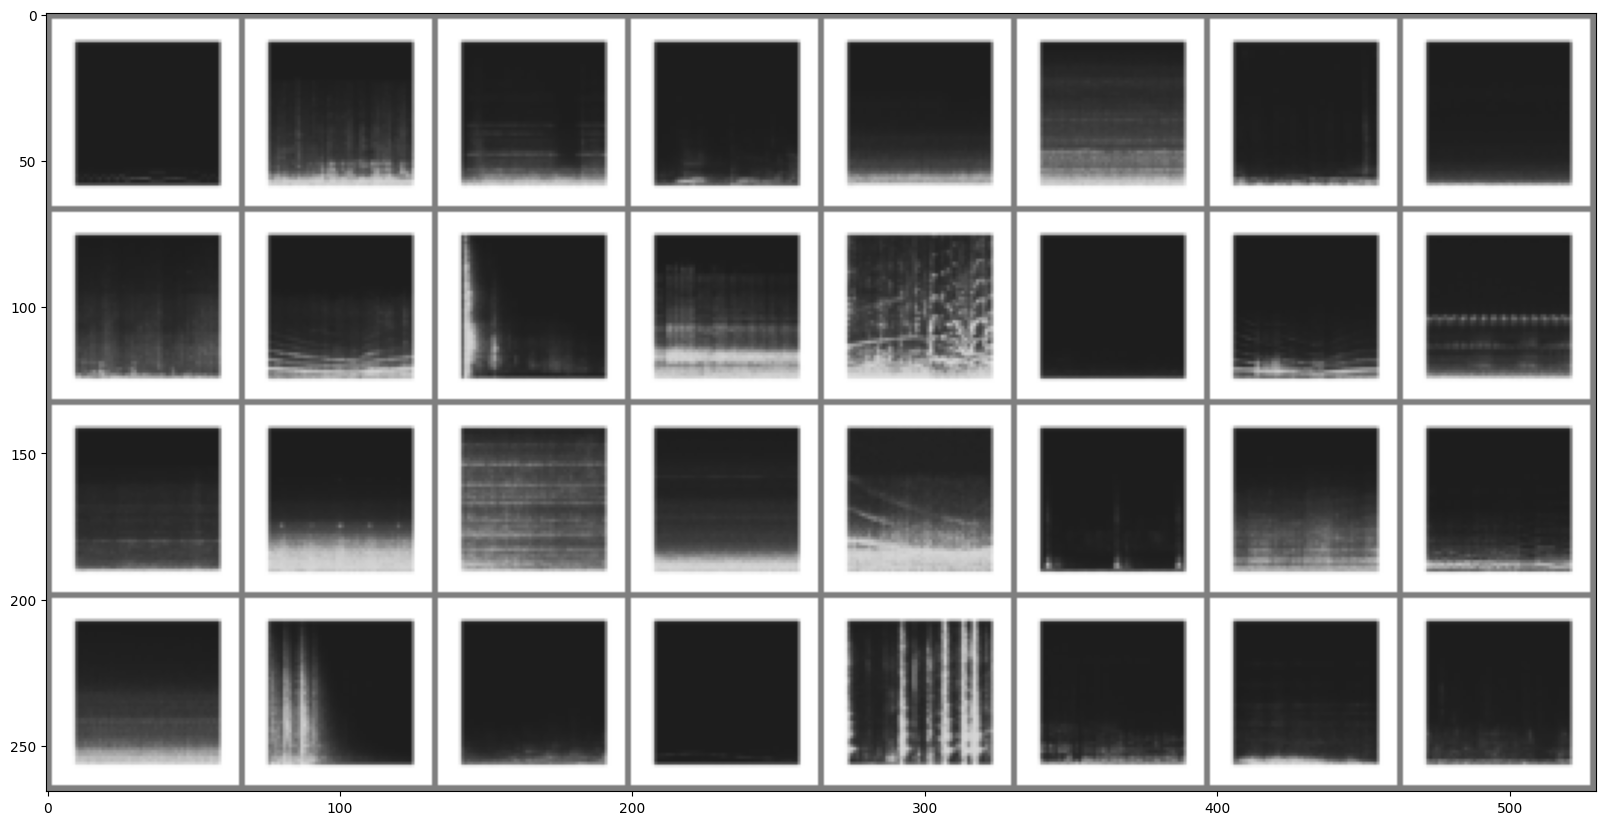

In [9]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=[20, 20])
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

transform = transforms.Compose([
      transforms.Resize((64,64)),
      transforms.ToTensor(),
      transforms.Normalize((0.5), (0.5))
      ])

train_data = AudioFolder(x_train, y_train, audioPath, windowType = 'hann', windowSize = 1024, hopinpercent = 50, tranforms=transform, derivation='manual')

dataset_sizes = {
    'train': len(train_data)
}
# class_names = train_data.classes
# To display the images using next(intr(loader)) function, which is eq to batch_size
train_dataloader = DataLoader(dataset=train_data,batch_size=32,shuffle=True,drop_last=True)
inputs, classes = next(iter(train_dataloader))
out = utils.make_grid(inputs)
imshow(out)#, title=[class_names[x] for x in classes])



In [26]:
def dataloaders(x_train, y_train,x_test, y_test,x_val, y_val, windowType, windowSize, hopinpercent):
  transform = transforms.Compose([
      transforms.Resize((64,64)),
      transforms.ToTensor(),
      transforms.Normalize((0.5), (0.5))
      ])

  train_data = AudioFolder(x_train, y_train, audioPath, windowType = windowType, windowSize = windowSize, hopinpercent = hopinpercent, tranforms=transform)
  test_data = AudioFolder(x_test, y_test, audioPath,  windowType = windowType, windowSize = windowSize, hopinpercent = hopinpercent, tranforms=transform)
  valid_data = AudioFolder(x_val, y_val, audioPath,  windowType = windowType, windowSize = windowSize, hopinpercent = hopinpercent, tranforms=transform)

  batch_size = 32
  train_dataloader = DataLoader(dataset=train_data,batch_size=batch_size,shuffle=True,drop_last=True)
  valid_dataloader = DataLoader(dataset=valid_data)
  test_dataloader = DataLoader(dataset=test_data,batch_size=64,shuffle=False)

  return train_dataloader, test_dataloader, valid_dataloader

In [27]:
import pickle
def trainNfit(trainingStart, num_epochs,model,train_loader,test_loader,valid_dataloader, datasetNM, device, criterion, optimizer, savestr):
    #Training
    # model = CNN().to(device)
    # criterion = nn.CrossEntropyLoss()
    # optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    dct = {"trl":[], "tra":[], "tsl":[], "tsa": [], "tra5":[], "tsa5":[], "vall":[], "vala":[], "vala5":[]}
    if trainingStart:
        for epoch in range(num_epochs):
            print(f'Epoch - {epoch}')
            print('-' * 10)
            running_loss = 0.0
            running_corrects = 0
            running_total = 0
            running_corrects_t5 = 0
            tst_correct = 0
            tst_total = 0
            tst_loss = 0.0
            tst_running_corrects_t5 = 0
            val_correct = 0
            val_total = 0
            val_loss = 0.0
            val_running_corrects_t5 = 0
            model.train()
            for batch_X, batch_y in train_loader:
                batch_X = batch_X.to(device)
                batch_y = batch_y.to(device)
                # Forward pass
                outputs = model(batch_X)
                ActualY = batch_y #torch.tensor(batch_y)#torch.max(batch_y, 1)[1]
                loss = criterion(outputs, ActualY)

                # Backward pass and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                running_loss += loss.item() * batch_X.size(0)
                _, predicted = torch.max(outputs.data, 1)
                _, predicted_t5 = torch.topk(outputs.data,5,1)
                running_total += batch_y.size(0)
                running_corrects += (predicted == ActualY).sum().item()
                running_corrects_t5 = running_corrects_t5 + sum([x in y for x, y in zip(ActualY ,predicted_t5)])
            # if f:
            train_loss = running_loss / len(train_loader.dataset)
            train_accuracy = 100 * running_corrects / running_total
            train_accuracy_t5 = 100 * running_corrects_t5 / running_total
            model.eval()
            with torch.no_grad():
                for data in test_loader:
                        images, labels = data
                        images = images.to(device)
                        labels = labels.to(device)
                        ActualLabel = labels

                        outputs = model(images)
                        _, predicted = torch.max(outputs.data, 1)
                        _, predicted_t5 = torch.topk(outputs.data,5,1)
                        tst_total += labels.size(0)
                        tst_correct += (predicted == ActualLabel).sum().item()
                        tst_loss += criterion(outputs, labels).item() * labels.size(0)
                        tst_running_corrects_t5 = running_corrects_t5 + sum([x in y for x, y in zip(ActualLabel ,predicted_t5)])

                tst_accuracy = 100 * tst_correct / tst_total
                tst_accuracy_t5 = 100 * tst_running_corrects_t5 / tst_total
                tst_loss = tst_loss/len(test_loader.dataset)

                for data in valid_dataloader:
                        images, labels = data
                        images = images.to(device)
                        labels = labels.to(device)
                        ActualLabel = labels

                        outputs = model(images)
                        _, predicted = torch.max(outputs.data, 1)
                        _, predicted_t5 = torch.topk(outputs.data,5,1)
                        val_total += labels.size(0)
                        val_correct += (predicted == ActualLabel).sum().item()
                        val_loss += criterion(outputs, labels).item() * labels.size(0)
                        val_running_corrects_t5 = running_corrects_t5 + sum([x in y for x, y in zip(ActualLabel ,predicted_t5)])


                val_accuracy = 100 * val_correct / val_total
                val_accuracy_t5 = 100 * val_running_corrects_t5 / val_total
                val_loss = val_loss/len(test_loader.dataset)

            dct["trl"].append(train_loss)
            dct["tra"].append(train_accuracy)
            dct["tra5"].append(train_accuracy_t5)
            dct["tsl"].append(tst_loss)
            dct["tsa"].append(tst_accuracy)
            dct["tsa5"].append(tst_accuracy_t5)
            dct["vall"].append(val_loss)
            dct["vala"].append(val_accuracy)
            dct["vala5"].append(val_accuracy_t5)
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss} - Train Accuracy: {train_accuracy}, Test Loss: {tst_loss}, Test Accuracy: {tst_accuracy}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')

        # Save the trained model
        with open(f'{modelPath}/{datasetNM}_{savestr}.pickle', 'wb') as handle:
            pickle.dump(dct, handle)
        torch.save(model.state_dict(), f'{modelPath}/model_{datasetNM}_{savestr}.pth')


In [20]:
class CNNSPEC(nn.Module):
    def __init__(self, poolType = "Max"):
        super(CNNSPEC, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        if poolType == "Max":
            self.layer2 = nn.Sequential(
                nn.Conv2d(32, 64, kernel_size=3),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2)
            )
        else:
            self.layer2 = nn.Sequential(
                nn.Conv2d(32, 64, kernel_size=3),
                nn.ReLU(),
                nn.AvgPool2d(kernel_size=2, stride=2)
            )
        self.fc1 = nn.Linear(64 * 14 * 14, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.Softmax = nn.Softmax(dim=1)


    def forward(self, x):
        # print(f"***********{x.shape}$$$$$$$$")
        x = self.layer1(x)
        # print(f"***********{x.shape}&&&&&&&&")
        x = self.layer2(x)
        # print(f"***********{x.shape}########")
        x = x.view(x.size(0), -1)
        # print(f"***********{x.shape}********")
        x = self.relu(self.fc1(x))
        # print(f"-----------{x.shape}----------")
        x = self.fc2(x)
        # x = self.Softmax(x)
        return x

In [12]:
# # params = [("hann", 1024, 50, "hann1024_50"),("hamming", 1024, 50, "hamming1024_50"),("Rectangle", 1024, 50, "Rect1024_50"),("hann", 2048, 50, "hann2048_50"), ("hann", 1024, 25, "hann1024_25"), ("hann", 1024, 5, "hann1024_5")]
# params = [("hamming", 1024, 50, "hamming1024_50")]
# for wint, wins, hops, mname in params:
#   print(f"Training for window Tyoe - {wint}, Window Size - {wins}, Hop Size - {hops}")
#   train_dataloader, test_dataloader, valid_dataloader = dataloaders(x_train, y_train,x_test, y_test,x_val, y_val, wint, wins, hops)
#   learning_rate = 0.001
#   num_epochs = 5
#   trainingStart = True
#   datasetNM = "AUDIO"
#   device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#   criterion = nn.CrossEntropyLoss()
#   model = CNNSPEC().to(device)
#   model.to(device)
#   optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)#, weight_decay=2e-5
#   trainNfit(trainingStart, num_epochs,model,train_dataloader, test_dataloader, valid_dataloader, datasetNM, device, criterion, optimizer, mname)

Training for window Tyoe - hamming, Window Size - 1024, Hop Size - 50
Epoch - 0
----------
Epoch [1/5], Train Loss: 2.0045249982190874 - Train Accuracy: 26.799242424242426, Test Loss: 1.7424245601567, Test Accuracy: 35.77832110839446, Validation Loss: 0.8535064331573884, Validation Accuracy: 36.0
Epoch - 1
----------
Epoch [2/5], Train Loss: 1.523231773808725 - Train Accuracy: 45.265151515151516, Test Loss: 1.441625963893477, Test Accuracy: 47.59576202118989, Validation Loss: 0.6809358905434123, Validation Accuracy: 50.333333333333336
Epoch - 2
----------
Epoch [3/5], Train Loss: 1.286676038988814 - Train Accuracy: 54.308712121212125, Test Loss: 1.2329132455873995, Test Accuracy: 57.45721271393643, Validation Loss: 0.5998399282094025, Validation Accuracy: 54.5
Epoch - 3
----------
Epoch [4/5], Train Loss: 1.1374586355697445 - Train Accuracy: 58.854166666666664, Test Loss: 1.130255715382614, Test Accuracy: 59.494702526487366, Validation Loss: 0.5414451683852346, Validation Accuracy: 62.

In [31]:
from torchsummary import summary
model = CNNSPEC()
model.load_state_dict(torch.load(f'{modelPath}model_AUDIO_hann1024_50.pth',map_location=torch.device('cpu')))
# model.eval()
summary(model, (1, 64, 64))

<ipython-input-31-7531fa5eb9bf>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'{modelPath}model_AUDIO_hann1024_50.pth',map_location=torc

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 62, 62]             320
              ReLU-2           [-1, 32, 62, 62]               0
         MaxPool2d-3           [-1, 32, 31, 31]               0
            Conv2d-4           [-1, 64, 29, 29]          18,496
              ReLU-5           [-1, 64, 29, 29]               0
         MaxPool2d-6           [-1, 64, 14, 14]               0
            Linear-7                  [-1, 128]       1,605,760
              ReLU-8                  [-1, 128]               0
            Linear-9                   [-1, 10]           1,290
Total params: 1,625,866
Trainable params: 1,625,866
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 3.03
Params size (MB): 6.20
Estimated Total Size (MB): 9.25
---------------------------------------

In [24]:
def compute_confusion_matrix(true, pred):
  #https://stackoverflow.com/questions/2148543/how-to-write-a-confusion-matrix
  '''Computes a confusion matrix using numpy for two np.arrays
  true and pred.

  Results are identical (and similar in computation time) to:
    "from sklearn.metrics import confusion_matrix"

  However, this function avoids the dependency on sklearn.'''

  K = len(np.unique(true)) # Number of classes
  result = np.zeros((K, K))

  for i in range(len(true)):
    result[true[i]][pred[i]] += 1

  return result

def getModelMetric(cnfMat):
  #https://medium.com/data-science-in-your-pocket/calculating-precision-recall-for-multi-class-classification-9055931ee229
    TP = np.diag(cnfMat)
    FP = np.sum(cnfMat, axis=0) - TP
    FN = np.sum(cnfMat, axis=1) - TP

    precision = TP/(TP+FP)
    recall = TP/(TP+FN)

    return np.sum(precision)/3, np.sum(recall)/3

Training for window Type - hann, Window Size - 1024, Hop Size - 50
Accuracy on the test set: 66.05%


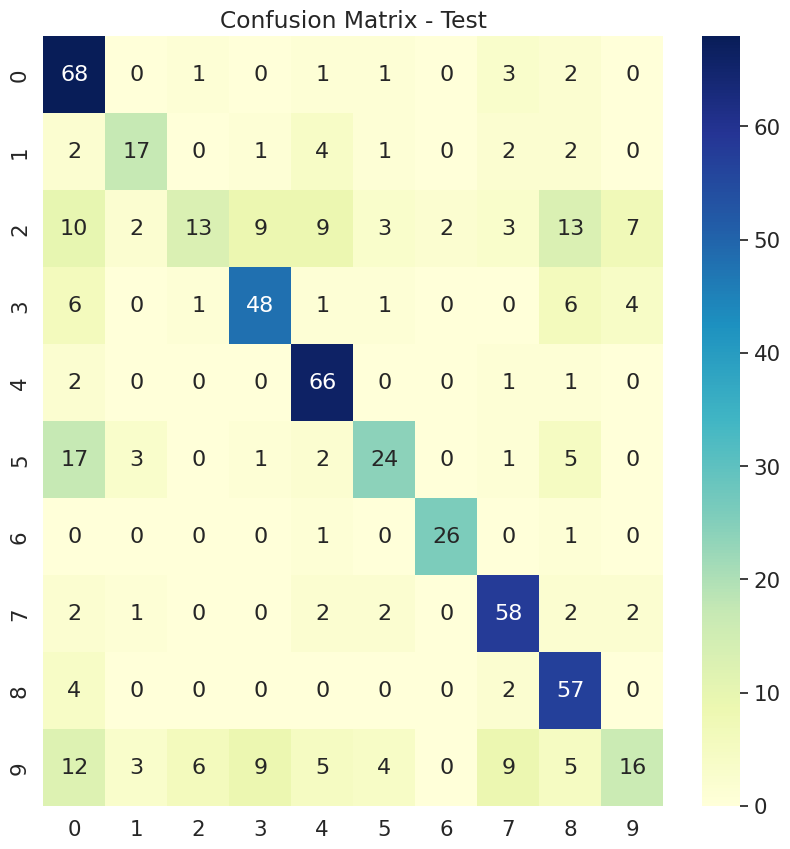

In [33]:
params = [("hann", 1024, 50, "hann1024_50")]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
for wint, wins, hops, mname in params:
  print(f"Training for window Type - {wint}, Window Size - {wins}, Hop Size - {hops}")
  train_dataloader, test_dataloader, valid_dataloader = dataloaders(x_train, y_train,x_test, y_test,x_val, y_val, wint, wins, hops)
  model.eval()
  with torch.no_grad():
      correct = 0
      total = 0
      all_preds = []
      all_labels = []
      for batch_X, batch_y in valid_dataloader:
          batch_X = batch_X.to(device)
          batch_y = batch_y.to(device)
          outputs = model(batch_X)
          _, predicted = torch.max(outputs.data, 1)
          total += batch_y.size(0)
          correct += (predicted == batch_y).sum().item()
          all_preds.extend(predicted)
          all_labels.extend(batch_y)

      print(f'Accuracy on the test set: {100 * correct / total:.2f}%')

confTest = compute_confusion_matrix(all_labels,all_preds)
fig, ax = plt.subplots(1,1)
fig.set_size_inches(10,10)
df_cm = pd.DataFrame(confTest, range(10), range(10))
sn.set_theme(font_scale=1.4)
ax.set_title("Confusion Matrix - Test")
precision, recall = getModelMetric(confTest)
s = sn.heatmap(df_cm, annot=True, cmap="YlGnBu", annot_kws={"size": 16}, ax=ax)

Text(4.44444444444443, 0.5, 'Accuracy')

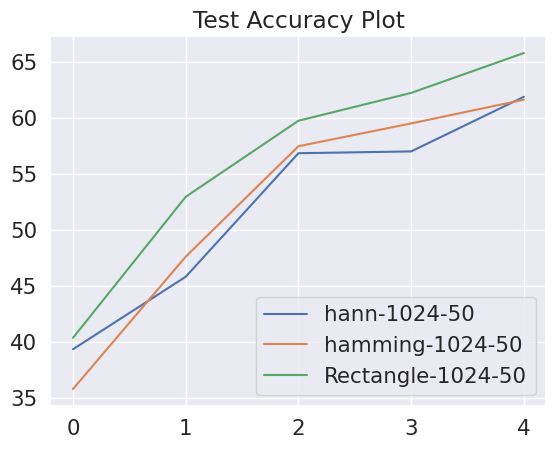

In [34]:
allModels = {
 ("hann", 1024, 50, "hann1024_50", (0,1,2)): ("AUDIO_hann1024_50.pickle", "model_AUDIO_hann1024_50.pth"),
 ("hamming", 1024, 50, "hamming1024_50", (0,)): ("AUDIO_hamming1024_50.pickle", "model_AUDIO_hamming1024_50.pth"),
 ("Rectangle", 1024, 50, "Rect1024_50", (0,)): ("AUDIO_Rect1024_50.pickle", "model_AUDIO_Rect1024_50.pth")
}

for j, (k,v) in enumerate(allModels.items()):
    wint, wins, hops, mname, tp = k
    lst = list(tp)
    pickleFile = v[0]
    with open(f"{modelPath}{pickleFile}", 'rb') as handle:
            dctr = pickle.load(handle)
    plt.plot([i for i in range(len(dctr["tsa"]))],dctr["tsa"], label=f"{k[0]}-{k[1]}-{k[2]}")


plt.legend()
plt.title("Test Accuracy Plot")
# ax.tight_layout()
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")

In [ ]:
musicFiles = ["Jaane_Kya.wav","Jai_Ho.wav","Sifar_Song.wav","Tuhi_Re.wav"]
fig = plt.figure(constrained_layout=True)
fig.set_size_inches(15,15)
fig.suptitle('Song Frequency Analysis')

# create 3x1 subfigs
subfigs = fig.subfigures(4,1)
for row, (subfig,file) in enumerate(zip(subfigs,musicFiles)):
    subfig.suptitle(file.split(".")[0])
    # create 1x3 subplots per subfig
    axs = subfig.subplots(nrows=1, ncols=3)
    fs, data = read(f"{musicPath}{file}")
    data = data[0:math.floor(len(data[:,0])/2),0]
    time = np.arange(0,len(data))/fs
    axs[0].plot(time, data)

    # signalX = scipy.fftpack.fft(data)
    signalX = fft(data)
    hz = np.linspace(0,fs/2,int(np.floor(len(data)/2) + 1))
    fourtrans = 2*np.abs(signalX)/len(data)
    axs[1].stem(hz, fourtrans[0:len(hz)])

    frex,time,pwr = scipy.signal.spectrogram(data,fs)
    axs[2].pcolormesh(time,frex,pwr,vmin=0,vmax=9)
        # ax.plot()
        # ax.set_title(f'Plot title {col}')